# Note:

**В этом ноутбуке, а также в аналогичном для Prophet рассматривается влияние выбросов на качество модели.**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pyramid
import math
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from sklearn import metrics
import pandas as pd
from pyramid.arima import auto_arima

np.random.seed(123)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [2]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y.squeeze()

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [3]:
Time = np.arange(0,300)

# Plotting features

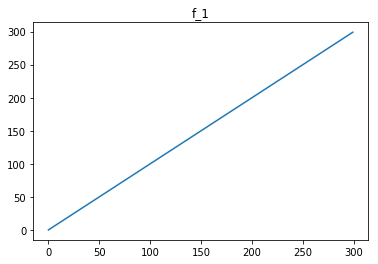

In [4]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

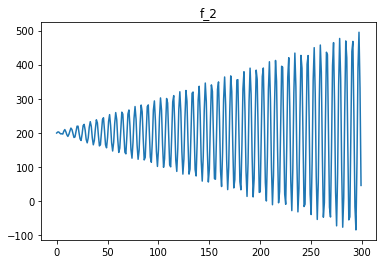

In [5]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

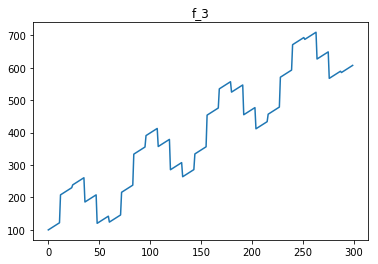

In [6]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

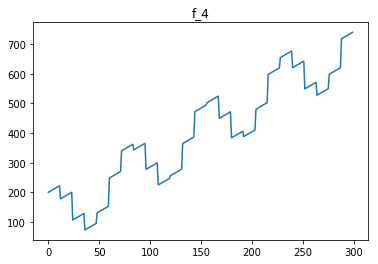

In [7]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

# Generating exog features

In [8]:
Exog = np.concatenate([f_1(Time), f_2(Time), f_3(Time, period=12),f_4(Time, period=12)], axis = 1)
print (Exog.shape)

(300, 4)


# Generating time series

In [9]:
y_1 = generate_ts_1(Exog)
y_2 = generate_ts_2(Exog)

# Границы train and test

In [10]:
start_point = 80
middle_point = 125
end_point = 175

# Добавим выбросов в данные

In [11]:
np.random.seed(123)

number_of_outliers = 7

idx_1 = np.random.randint(low = start_point, high = middle_point, size = number_of_outliers)
idx_2 = np.random.randint(low = start_point, high = middle_point, size = number_of_outliers)

y_1[idx_1] = y_1[idx_1] + np.random.normal(scale = 50, size = number_of_outliers)
y_2[idx_2] = y_2[idx_2] + np.random.normal(scale = 50, size = number_of_outliers)

 # Plotting time-series

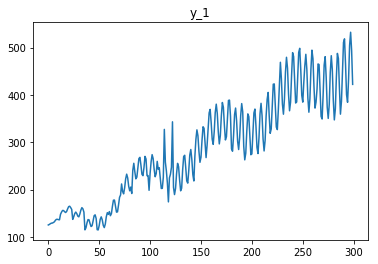

In [12]:
plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

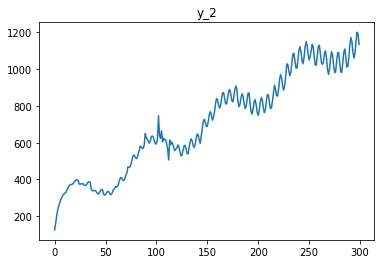

In [13]:
plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

# Pyramid_functions

In [14]:
def pyramid_stepwise(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, period = 12, n_periods = 100,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore', information_criterion = 'aic',trend = 'c',
                          suppress_warnings=True, n_jobs = 1,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data, exogenous=Exog_train, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore',information_criterion = 'oob',trend = 'c',
                          suppress_warnings=True, n_jobs = 1,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

In [15]:
def pyramid_random_search(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, 
                          period = 12, n_periods = 100, n_fits = 200, n_jobs = 1, random_state = 42,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data,start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                    start_P=0, start_Q = 0, n_jobs=n_jobs, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                    error_action='ignore', information_criterion = 'aic', trend = 'c',
                    suppress_warnings=True,
                    stepwise=False, random=True, random_state=random_state, n_fits = n_fits)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data,exogenous=Exog_train,start_p=0, start_q=0, max_p=5, max_q=5,m=period,
                    start_P=0, start_Q = 0, n_jobs=n_jobs, max_d = 2, max_D = 2, max_P=5, max_Q=5, trace=False,
                    error_action='ignore',  
                    suppress_warnings=True, information_criterion = 'oob', trend = 'c',
                    stepwise=False, random=True, random_state=42,
                    n_fits=1000)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

# Train-test-split

In [16]:
start_point = 80
middle_point = 125
end_point = 175


y_train_1 = y_1[start_point: middle_point]
y_test_1 = y_1[middle_point: end_point]

y_train_2 = y_2[start_point: middle_point]
y_test_2 = y_2[middle_point: end_point]

exog_train = Exog[start_point: middle_point]
exog_test = Exog[middle_point: end_point]

print("samples in train: ", y_train_1.shape, "samples in test: ", y_test_1.shape)

samples in train:  (45,) samples in test:  (50,)


## Data frame 1

# without exogenous:

# StepWise

In [17]:
model_1_st, in_sample_preds_1_st,next_validate_1_st = pyramid_stepwise(y_train_1, Exog_train=exog_train,
                                    Exog_test=exog_test, exog_flag=False, n_periods = len(y_test_1))
print (model_1_st.summary())

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood                -215.406
Date:                            Fri, 13 Jul 2018   AIC                            440.812
Time:                                    11:56:08   BIC                            449.846
Sample:                                         0   HQIC                           444.180
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    172.6809    204.573      0.844      0.399    -228.275     573.637
ar.L1          0.1805      0.200   

In [18]:
in_sample_preds_1_st.shape, next_validate_1_st.shape

((45,), (50,))

In [19]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_st, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_st, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.25 
 MAE:  59.341


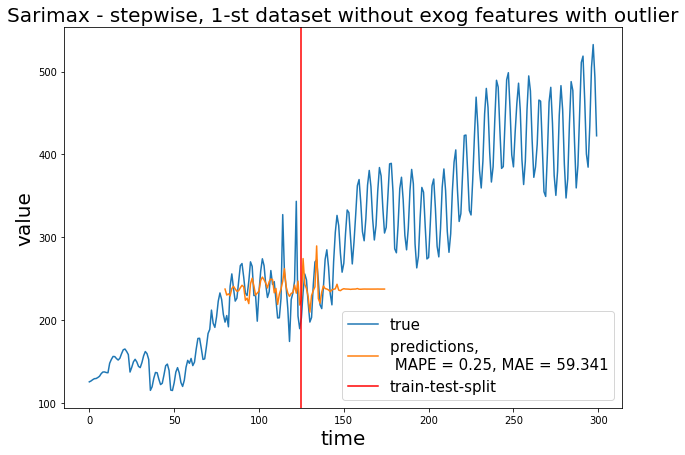

In [20]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_st, next_validate_1_st]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 1-st dataset without exog features with outlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Random Search

In [21]:
model_1_rs, in_sample_preds_1_rs,next_validate_1_rs = pyramid_random_search(y_train_1, Exog_train=exog_train,Exog_test=exog_test,
                        exog_flag=False, n_fits = 5000, n_periods = len(y_test_1))
print (model_1_rs.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(5, 0, 0)   Log Likelihood                -206.855
Date:                Fri, 13 Jul 2018   AIC                            427.709
Time:                        11:56:56   BIC                            440.356
Sample:                             0   HQIC                           432.424
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    353.4896    111.877      3.160      0.002     134.214     572.765
ar.L1          0.1819      0.163      1.115      0.265      -0.138       0.502
ar.L2         -0.1927      0.192     -1.005      0.3

In [22]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_rs, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_rs, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.257 
 MAE:  60.91


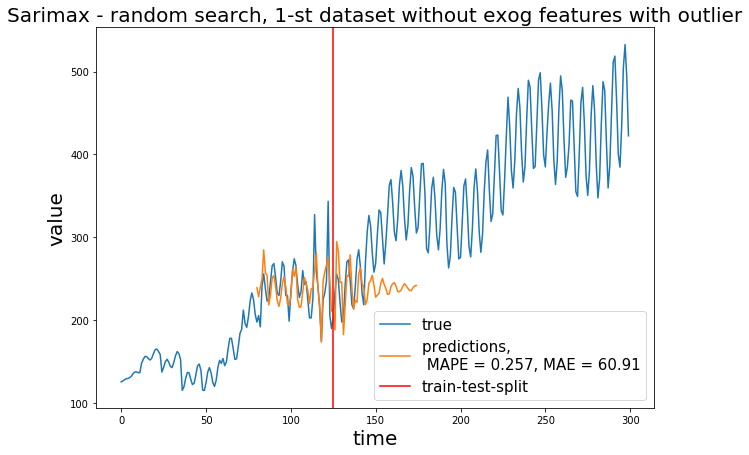

In [23]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_rs, next_validate_1_rs]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 1-st dataset without exog features with outlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

# with exogenous:

# StepWise

In [24]:
model_1_st_we, in_sample_preds_1_st_we, next_validate_1_st_we = pyramid_stepwise(y_train_1, 
                    Exog_train=exog_train, Exog_test=exog_test, exog_flag=True, n_periods = len(y_test_1))
print (model_1_st_we.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:                        SARIMAX   Log Likelihood                -198.542
Date:                Fri, 13 Jul 2018   AIC                            409.084
Time:                        11:57:19   BIC                            419.924
Sample:                             0   HQIC                           413.125
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1361    226.647     -0.001      1.000    -444.356     444.084
x1             0.5718      0.809      0.707      0.480      -1.013       2.157
x2             0.3115      0.080      3.875      0.0

In [25]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_st_we, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_st_we, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.038 
 MAE:  11.144


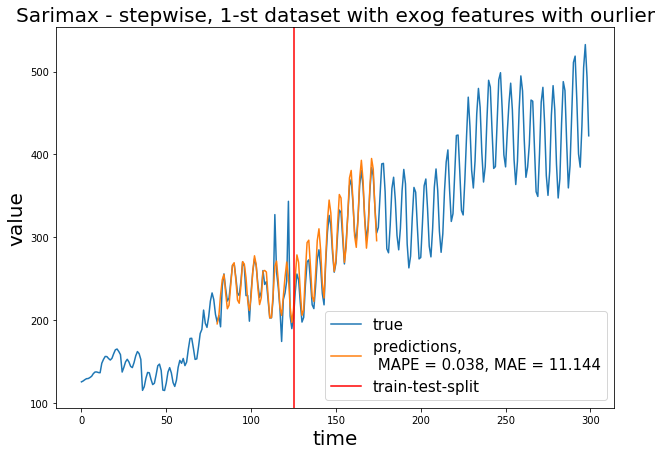

In [26]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_st_we, next_validate_1_st_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 1-st dataset with exog features with ourlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

# RandomSearch

In [27]:
model_1_rs_we, in_sample_preds_1_rs_we,next_validate_1_rs_we = pyramid_random_search(y_train_1,
            Exog_train=exog_train, Exog_test=exog_test, exog_flag=True, n_fits =5000, n_periods = len(y_test_1))
 
print (model_1_rs_we.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 12)   Log Likelihood                -194.571
Date:                            Fri, 13 Jul 2018   AIC                            407.142
Time:                                    11:58:02   BIC                            423.402
Sample:                                         0   HQIC                           413.204
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1614     68.658      0.017      0.987    -133.405     135.728
x1             0.5974      0.320   

In [28]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_rs_we, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_rs_we, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.043 
 MAE:  12.333


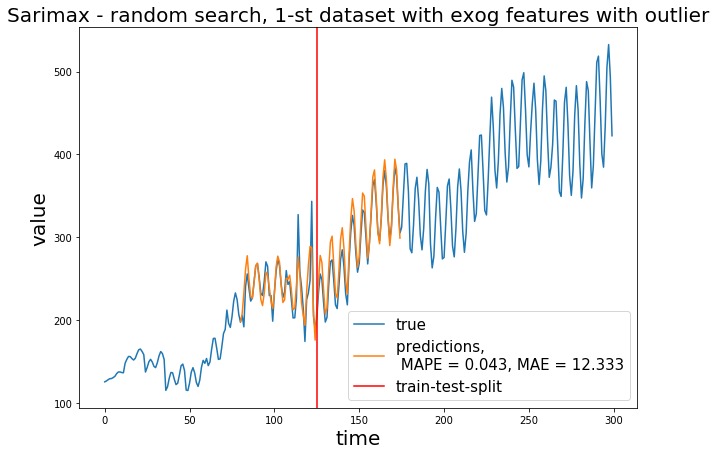

In [29]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_rs_we, next_validate_1_rs_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 1-st dataset with exog features with outlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

## Data frame 2

# without exogenous:

# Stepwise

In [30]:
model_2_st, in_sample_preds_2_st,next_validate_2_st = pyramid_stepwise(y_train_2, Exog_train=exog_train,
                                Exog_test=exog_test, exog_flag=False, n_periods = len(y_test_1))

print (model_2_st.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -223.254
Date:                Fri, 13 Jul 2018   AIC                            452.508
Time:                        11:58:03   BIC                            457.928
Sample:                             0   HQIC                           454.529
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    252.6819     66.328      3.810      0.000     122.682     382.682
ar.L1          0.5722      0.113      5.052      0.000       0.350       0.794
sigma2      1183.1589    160.572      7.368      0.0

In [31]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_st, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_st, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.218 
 MAE:  128.848


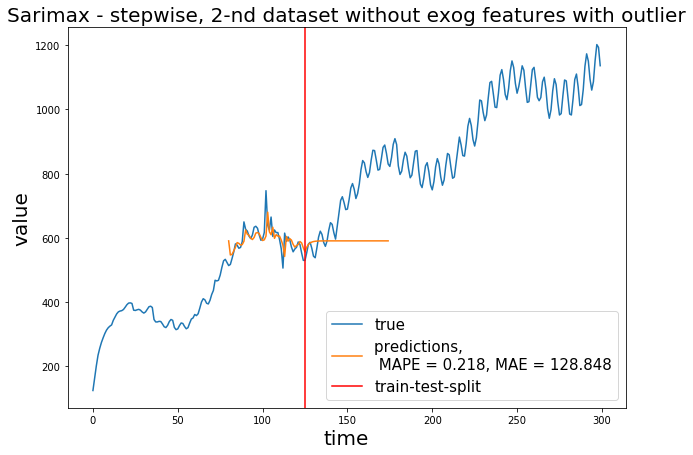

In [32]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_st, next_validate_2_st]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 2-nd dataset without exog features with outlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Random Search

In [33]:
model_2_rs, in_sample_preds_2_rs,next_validate_2_rs = pyramid_random_search(y_train_2, Exog_train=exog_train,
                    Exog_test=exog_test, exog_flag=False, n_fits = 5000, n_periods = len(y_test_2))


print (model_2_rs.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(3, 0, 5)   Log Likelihood                -216.198
Date:                Fri, 13 Jul 2018   AIC                            452.396
Time:                        12:00:23   BIC                            470.462
Sample:                             0   HQIC                           459.131
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    217.0667    579.742      0.374      0.708    -919.207    1353.341
ar.L1          1.6692      0.975      1.712      0.087      -0.242       3.581
ar.L2         -1.6355      1.093     -1.496      0.1

In [34]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_rs, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_rs, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.209 
 MAE:  124.542


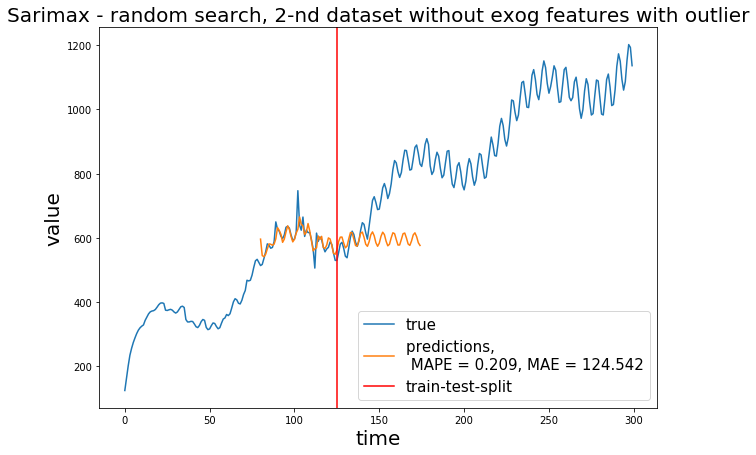

In [35]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_rs, next_validate_2_rs]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 2-nd dataset without exog features with outlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

# with exogenous:

In [36]:
model_2_st_we, in_sample_preds_2_st_we,next_validate_2_st_we = pyramid_stepwise(y_train_2,
                Exog_train=exog_train, Exog_test=exog_test, exog_flag=True, n_periods = len(y_test_2))


print (model_2_st_we.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:                        SARIMAX   Log Likelihood                -203.495
Date:                Fri, 13 Jul 2018   AIC                            418.990
Time:                        12:00:24   BIC                            429.830
Sample:                             0   HQIC                           423.031
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1055    146.689      0.001      0.999    -287.400     287.611
x1             1.1855      0.970      1.222      0.222      -0.716       3.087
x2             0.3144      0.046      6.858      0.0

In [37]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_st_we, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_st_we, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.049 
 MAE:  37.894


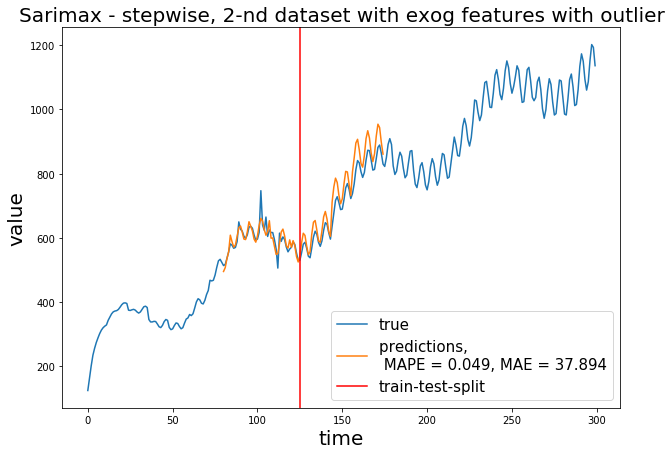

In [38]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_st_we, next_validate_2_st_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 2-nd dataset with exog features with outlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

In [39]:
model_2_rs_we, in_sample_preds_2_rs_we,next_validate_2_rs_we = pyramid_random_search(y_train_2,
    Exog_train=exog_train,Exog_test=exog_test, exog_flag=True,n_fits =5000, n_periods = len(y_test_2))


print (model_2_rs_we.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 12)   Log Likelihood                -202.505
Date:                            Fri, 13 Jul 2018   AIC                            423.010
Time:                                    12:01:08   BIC                            439.270
Sample:                                         0   HQIC                           429.072
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2663    138.127      0.002      0.998    -270.457     270.990
x1             1.1237      0.737   

In [40]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_rs_we, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_rs_we, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.045 
 MAE:  34.881


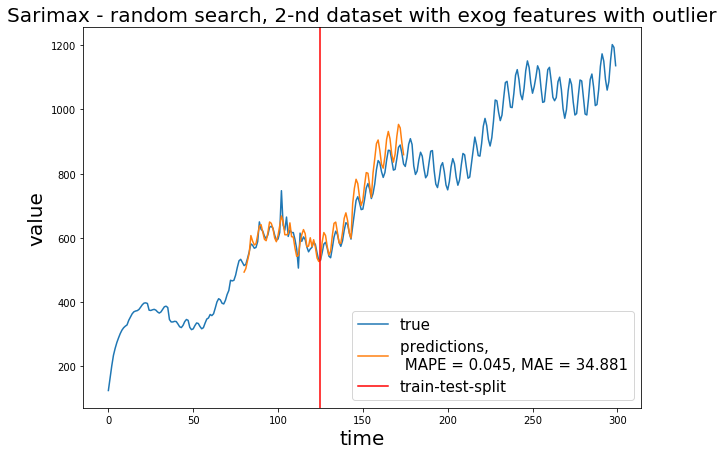

In [41]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_rs_we, next_validate_2_rs_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 2-nd dataset with exog features with outlier", size = 20)



plt.legend(fontsize = 15)

plt.show()

**Видимо, SARIMAX лучше справляется с наличием выбросов в обучающей выборке. Что противоречит выводам в статье Prophet, в которой авторы, наоборот, говорят что их Prophet лучше. Возможно, здесь многое зависит как от самого датасета, так и от выбросов, размера обучаюшей выборки и многого другого. ТРЕБУЕТ ОТДЕЛЬНЫХ ИССЛЕДОВАНИЙ!**